In [287]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = pd.read_csv("credit_card_default_analysis.csv", index_col=False) 
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1. Размер кредитного лимита (LIMIT_BAL)

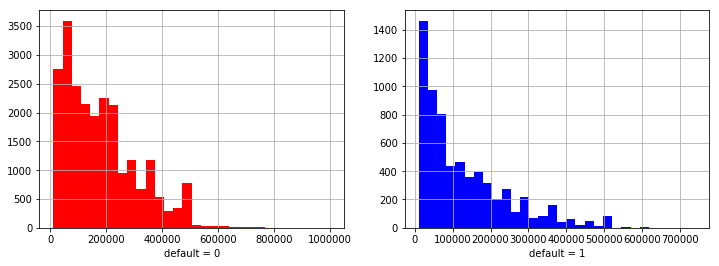

In [262]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data[data.default == 0].loc[:, 'LIMIT_BAL'], color = 'r', bins = 30)
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data[data.default == 1].loc[:, 'LIMIT_BAL'], color = 'b', bins = 30)
pylab.xlabel('default = 1')

pylab.show()

#### Для проверки гипотезы равенстава медиан найдём сами медианы и их доверительые интервалы с помощью будстрепа

In [20]:
print('медиана кредитного лимита людей, вернувших кредит =', data[data.default == 0].loc[:, 'LIMIT_BAL'].median())
print('медиана кредитного лимита людей, не вернувших кредит =', data[data.default == 1].loc[:, 'LIMIT_BAL'].median())

медиана кредитного лимита людей, вернувших кредит = 150000.0
медиана кредитного лимита людей, не вернувших кредит = 90000.0


In [22]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [23]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [264]:
np.random.seed(0)

not_default_median_scores = list(map(np.median, get_bootstrap_samples(data[data.default == 0].loc[:, 'LIMIT_BAL'].to_numpy(), 1000)))
default_median_scores = list(map(np.median, get_bootstrap_samples(data[data.default == 1].loc[:, 'LIMIT_BAL'].to_numpy(), 1000)))
delta_median = list(map(lambda x: x[0] - x[1], zip(not_default_median_scores, default_median_scores)))

print("95% доверительный интервал для медиан кредитных лимитов людей, вернувших кредит:",  stat_intervals(not_default_median_scores, 0.05))
print("95% доверительный интервал для медиан кредитных лимитов людей, не вернувших кредит:",  stat_intervals(default_median_scores, 0.05))
print("95% доверительный интервал для разности медиан кредитных лимитов:",  stat_intervals(delta_median, 0.05))

95% доверительный интервал для медиан кредитных лимитов людей, вернувших кредит: [150000. 150000.]
95% доверительный интервал для медиан кредитных лимитов людей, не вернувших кредит: [80000. 90000.]
95% доверительный интервал для разности медиан кредитных лимитов: [60000. 70000.]


Вывод: 95 % доверительный интервал разности медиан кредитных лимитов не содержит ноль, медианы отличиются значимо.

#### Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [27]:
stats.mannwhitneyu(data[data.default == 0].loc[:, 'LIMIT_BAL'], data[data.default == 1].loc[:, 'LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Вывод: Нулевая гипотеза уверенно отвергается, распределения двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул значимо отличаются. Странно было бы ожидать другого результата. С практической точки зрения эту зависимость неоходимо учитывать в скоринговой модели, тем более что она весьма интерпритируема.

## 2. Пол (SEX)

[[Text(0, 0, 'Male'), Text(0, 0, 'Female')]]

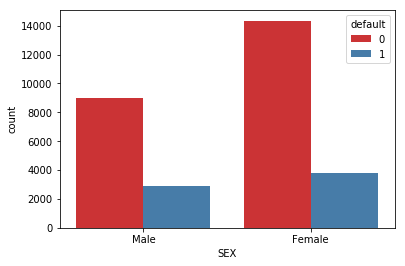

In [280]:
sns.countplot(x='SEX', hue='default', data=data, palette='Set1').set(xticklabels=['Male', 'Female'])

#### Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [35]:
def proportions_confint_diff_ind(sum_sample1, len_sample1, sum_sample2, len_sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum_sample1) / len_sample1
    p2 = float(sum_sample2) / len_sample2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len_sample1 + p2 * (1 - p2)/ len_sample2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len_sample1 + p2 * (1 - p2)/ len_sample2)
    
    return (left_boundary, right_boundary)

In [47]:
print("95%% доверительный интервал для разности долей: [%f, %f]" % proportions_confint_diff_ind(
                    data[(data.default == 0) & (data.SEX == 2)].loc[:, 'SEX'].count(),
                    data[data.default == 0].loc[:, 'SEX'].count(),
                    data[(data.default == 1) & (data.SEX == 2)].loc[:, 'SEX'].count(),
                    data[data.default == 1].loc[:, 'SEX'].count(), alpha = 0.05))

95% доверительный интервал для разности долей: [0.033635, 0.060548]


Вывод: 95% доверительный интервал разности долей женщин среди людей вернувших и не вернувщих кредит не включает ноль, значит гипотеза о том, что гендерный состав вышеуказанных групп отличается принимается.

#### Z-критерий для разности долей (независимые выборки)

$H_0\colon $$\text{гендерный состав группы людей вернувших и не вернувших кредит не отличается} $

$H_1\colon $$\text{$H_0$ не нерна} $

In [51]:
def proportions_diff_z_stat_ind(sum_sample1, len_sample1, sum_sample2, len_sample2):
    n1 = len_sample1
    n2 = len_sample2
    
    p1 = float(sum_sample1) / n1
    p2 = float(sum_sample2) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [54]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

In [57]:
print('p-value', proportions_diff_z_test(proportions_diff_z_stat_ind(
                    data[(data.default == 0) & (data.SEX == 2)].loc[:, 'SEX'].count(),
                    data[data.default == 0].loc[:, 'SEX'].count(),
                    data[(data.default == 1) & (data.SEX == 2)].loc[:, 'SEX'].count(),
                    data[data.default == 1].loc[:, 'SEX'].count()), 'two-sided'))

p-value 4.472866521609831e-12


Вывод: гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается уверенно отвергается, женщины чаще отдают еркдит, чем мужчины. На практике в скоринговой модели необходимо учитывать этот фактор.

## 3. Образование (EDUCATION)

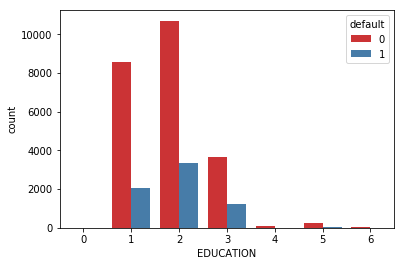

In [275]:
sns.countplot(x='EDUCATION', hue='default', data=data, palette='Set1')

#### Составим таблицу сопряжённости

In [236]:
education = pd.pivot_table(data[['EDUCATION', 'default']], index=['EDUCATION'], 
                           columns=['default'], aggfunc={'default': [np.size]})

In [237]:
education.fillna(value=0, inplace=True)
education

default        
              size        
default          0       1
EDUCATION                 
0             14.0     0.0
1           8549.0  2036.0
2          10700.0  3330.0
3           3680.0  1237.0
4            116.0     7.0
5            262.0    18.0
6             43.0     8.0

In [178]:
table = np.vstack((education['default', 'size', 0].to_numpy(), education['default', 'size', 1].to_numpy()))
table

array([[1.400e+01, 8.549e+03, 1.070e+04, 3.680e+03, 1.160e+02, 2.620e+02,
        4.300e+01],
       [0.000e+00, 2.036e+03, 3.330e+03, 1.237e+03, 7.000e+00, 1.800e+01,
        8.000e+00]])

#### Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг с помощью статистики  $\chi^2$

$H_0\colon $$\text{образование не влияет на то, вернет ли человек долг} $

$H_1\colon $$\text{$H_0$ не нерна} $

In [197]:
chi2, p, dof, expected = stats.chi2_contingency(table)
p

1.2332626245415605e-32

Вывод: $H_0$ уверенно отвергается

ожидаемых значения количества человек вернувших и не вернувших долг

In [225]:
expected_table = pd.DataFrame(expected.T).rename(columns={0: "default_0", 1: "default_1"})
expected_table.index.names = ['EDUCATION']
expected_table

,default_0,default_1
EDUCATION,,
0,10.9032,3.0968
1,8243.5980,2341.4020
2,10926.5640,3103.4360
3,3829.3596,1087.6404
4,95.7924,27.2076
5,218.0640,61.9360
6,39.7188,11.2812


таблицу сопряженности разности между наблюдаемым и ожидаемым количеством человек

In [226]:
difference_table = pd.DataFrame((table - expected).T).rename(columns={0: "default_0", 1: "default_1"})
difference_table.index.names = ['EDUCATION']
difference_table

,default_0,default_1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


для лучшей интерпритируемости масштабируем полученные значения поделив их на суммарное количество человек с данным образованием

In [228]:
difference_table['default_0_%'] = difference_table['default_0'] / (expected_table['default_0'] + expected_table['default_1'])
difference_table['default_1_%'] = difference_table['default_1'] / (expected_table['default_0'] + expected_table['default_1'])
difference_table

,default_0,default_1,default_0_%,default_1_%
EDUCATION,,,,
0,3.0968,-3.0968,0.221200,-0.221200
1,305.4020,-305.4020,0.028852,-0.028852
2,-226.5640,226.5640,-0.016149,0.016149
3,-149.3596,149.3596,-0.030376,0.030376
4,20.2076,-20.2076,0.164289,-0.164289
5,43.9360,-43.9360,0.156914,-0.156914
6,3.2812,-3.2812,0.064337,-0.064337


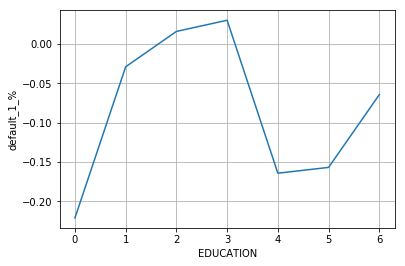

In [232]:
pylab.plot(expected_table.index, difference_table['default_1_%'])
pylab.grid()
pylab.xlabel('EDUCATION')
pylab.ylabel('default_1_%')
pylab.show()

Вывод: наличие образование "бакалавр" и "выпускник школы" немного повышает шансы на то, что человек не отдаст долг; наличие образования "доктор", "начальное образование" и "прочее" повышает шансы отдать долг более чем на 15%. Образование необходимо включать в скоринговую модель.

## 4. Семейное положение (MARRIAGE)

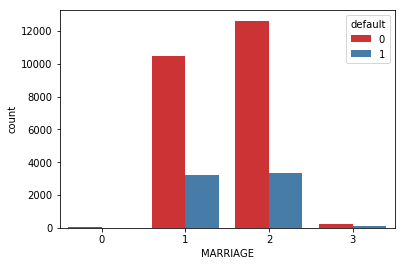

In [276]:
sns.countplot(x='MARRIAGE', hue='default', data=data, palette='Set1')

Людей, отказавшихся сообщить семейное положение и тех, по которым нет данных слишком мало и она не несут какой-либо смысловой нагрузки, поэтому будем искать корреляцию двух бинарных величин

In [251]:
marriage = pd.pivot_table(data[['MARRIAGE', 'default']], index=['MARRIAGE'], 
                           columns=['default'], aggfunc={'default': [np.size]}).drop([0, 3])

In [252]:
marriage

default      
            size      
default        0     1
MARRIAGE              
1          10453  3206
2          12623  3341

In [254]:
marriage_array = np.vstack((marriage['default', 'size', 0].to_numpy(), marriage['default', 'size', 1].to_numpy()))
marriage_array

array([[10453, 12623],
       [ 3206,  3341]], dtype=int64)

#### Проверим гипотезу о том, что семейное положение не влияет на то, вернет ли человек долг с помощью статистики  $\chi^2$

$H_0\colon $$\text{семейное положение не влияет на то, вернет ли человек долг} $

$H_1\colon $$\text{$H_0$ не нерна} $

In [256]:
chi2, p, dof, expected = stats.chi2_contingency(marriage_array)
p

1.5633210355976673e-07

In [286]:
v_kramer = np.sqrt((chi2) / (sum(marriage_array) * (min(marriage_array.shape[0], marriage_array.shape[1] - 1))))
v_kramer

0.030473764821587788

Вывод: $H_0$ уверенно отвергается, семейное положение влияет на то, вернёт ли человек долг. Коэффициент V Крамера показывает практически отсутствующую корреляцию между семейным положением и возвратом кредита. Причём, что странно, не замужние/не женатые люди отдают кредиты лучше. Семейное положение необходимо учитывать при построение скоринговой модели.

## 5. Возраст (AGE)

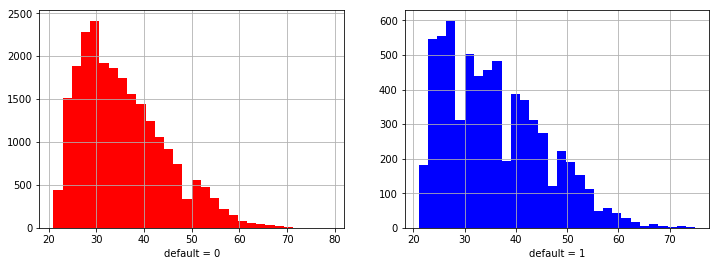

In [277]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data[data.default == 0].loc[:, 'AGE'], color = 'r', bins=30)
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data[data.default == 1].loc[:, 'AGE'], color = 'b', bins=30)
pylab.xlabel('default = 1')

pylab.show()

In [258]:
print('медиана возраст людей, вернувших кредит =', data[data.default == 0].loc[:, 'AGE'].median())
print('медиана возраст людей, не вернувших кредит =', data[data.default == 1].loc[:, 'AGE'].median())

медиана возраст людей, вернувших кредит = 34.0
медиана возраст людей, не вернувших кредит = 34.0


Вывод: медианные возрасты людей отдающих и не отдающих кредиты равны, потому что в обоих категориях присутствуют люди всех возрастов. С практической точки зрения информация бесполезная.

#### Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [259]:
stats.mannwhitneyu(data[data.default == 0].loc[:, 'AGE'], data[data.default == 1].loc[:, 'AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Вывод: на уровне значимости 0.05 нулевая гипотеза не отвергается, значит распределение возрастов в группах людей отдающих долг и не отдающих долг похожи. Возраст значимо не влияет на то, вернёт человек долг или нет, возможно его можно не учитывать при постоение модели.